In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
from scipy.stats import chi2_contingency
%matplotlib inline
from IPython.display import display

In [2]:
relevant_cols = ['CompanyName',
                'RegAddress.PostTown',
                'RegAddress.PostCode',
                'CompanyCategory',
                'DissolutionDate',
                'IncorporationDate',
                'SICCode.SicText_1',# Only look at SicText1 to keep things simple.
                ]
df = pd.concat([pd.read_csv('BasicCompanyData-2017-02-03-part{}_5.csv'.format(i), usecols=relevant_cols) for i in range(1,5+1)], ignore_index=True)

In [3]:
# Creating various raw data dataframes.
limited_categories = [
    'European Public Limited-Liability Company (SE)',
    "PRI/LBG/NSC (Private, Limited by guarantee, no share capital, use of 'Limited' exemption)",
    'PRI/LTD BY GUAR/NSC (Private, limited by guarantee, no share capital)',
    'PRIV LTD SECT. 30 (Private limited company, section 30 of the Companies Act)',
    'Private Limited Company',
    'Public Limited Company',
    ]
eh_df = df[df.apply(lambda x: isinstance(x['RegAddress.PostCode'], str) and x['RegAddress.PostCode'][:2]=='EH', axis=1)].copy()
def Date_to_Month(val):
    if isinstance(val,str):   
        return(val[3:])
    return(float('nan'))
eh_df['IncorporationMonth'] = eh_df.apply(lambda x:Date_to_Month(x['IncorporationDate']), axis=1)
eh012017_df = eh_df[eh_df['IncorporationMonth']=='01/2017']
eh012017_limited_df = eh012017_df[eh012017_df['CompanyCategory'].isin(limited_categories)]

# There are some companies in the EH area that are outside Edinburgh.
edi_df = df[df['RegAddress.PostTown']=='EDINBURGH'].copy()# Admittedly this isn't perfect, but seems to be better than using EH.
edi_df['IncorporationDate'] = pd.to_datetime(edi_df['IncorporationDate'])
edi_df['DissolutionDate'] = pd.to_datetime(edi_df['DissolutionDate'])

gla_df = df[df['RegAddress.PostTown']=='GLASGOW'].copy()
gla_df['IncorporationDate'] = pd.to_datetime(gla_df['IncorporationDate'])
gla_df['DissolutionDate'] = pd.to_datetime(gla_df['DissolutionDate'])

In [4]:
print(len(eh012017_df), len(eh012017_limited_df))
# 472 limited companies in the EH postcode area incorporated in January 2017.

626 472


In [5]:
# Creating SIC count/percentage dataframes.
edi_counts_list, gla_counts_list = [], []
irrelevant_sics = ['None Supplied', '99999 - Dormant Company', '74990 - Non-trading company']
years = [i for i in range(1980, 2016+1)]# 2017 data is incomplete.
for yr in years:
    # Dataframe of companies that exist at the end of the year yr.
    exist_edi_df = edi_df[(edi_df['IncorporationDate']<=pd.to_datetime('31/12/{}'.format(yr)))&(edi_df['DissolutionDate'].fillna(pd.to_datetime('31/12/2200'))>pd.to_datetime('31/12/{}'.format(yr)))]
    exist_gla_df = gla_df[(gla_df['IncorporationDate']<=pd.to_datetime('31/12/{}'.format(yr)))&(gla_df['DissolutionDate'].fillna(pd.to_datetime('31/12/2200'))>pd.to_datetime('31/12/{}'.format(yr)))]
    sic_counts_edi = exist_edi_df['SICCode.SicText_1'].value_counts().drop(irrelevant_sics)
    sic_counts_gla = exist_gla_df['SICCode.SicText_1'].value_counts().drop(irrelevant_sics)
    edi_counts_list.append(sic_counts_edi)
    gla_counts_list.append(sic_counts_gla)
edi_counts, gla_counts = pd.concat(edi_counts_list, axis=1).fillna(0), pd.concat(gla_counts_list, axis=1).fillna(0)
edi_counts.columns, gla_counts.columns = years, years
edi_counts.sort_values(2016, inplace=1, ascending=0)
gla_counts.sort_values(2016, inplace=1, ascending=0)
edi_percs, gla_percs = pd.DataFrame(), pd.DataFrame()
for i in years:
    edi_percs[i] = 100*edi_counts[i]/sum(edi_counts[i])
    gla_percs[i] = 100*gla_counts[i]/sum(gla_counts[i])

In [6]:
total_edi_2016, total_gla_2016 = sum(edi_counts[2016]), sum(gla_counts[2016])
print(total_edi_2016, total_gla_2016)
# We see that Glasgow has almost twice as many businesses (out of SICs that we consider).
# Edinburgh metro pop = 1.3 million, Glasgow = 2.3,
# so businesses per capita is slightly higher for Edinburgh.

21711 36189


In [7]:
edi_top, gla_top = pd.concat([edi_counts.head()[2016], edi_percs.head()[2016]], axis=1), pd.concat([gla_counts.head()[2016], gla_percs.head()[2016]], axis=1)
top_col_labels = ['Count', 'Percentage']
edi_top.columns, gla_top.columns = top_col_labels, top_col_labels
display(edi_top)
display(gla_top)
# Looks like there are some differences, if we look at the top 5:
# Edinurgh has more focus on science/tech, whereas Glasgow has more focus on real estate.
# Sample size should be large enough for significance, but can do a chi-squared test to confirm:
chi2_contingency(pd.concat([edi_counts[2016], gla_counts[2016]], axis=1).fillna(0))[1]
# p-value clearly significant.

,Count,Percentage
82990 - Other business support service activities n.e.c.,1953,8.995440
70229 - Management consultancy activities other than financial management,1269,5.844963
62020 - Information technology consultancy activities,1092,5.029708
"74909 - Other professional, scientific and technical activities n.e.c.",819,3.772281
68209 - Other letting and operating of own or leased real estate,688,3.168901


,Count,Percentage
82990 - Other business support service activities n.e.c.,2662,7.355826
68209 - Other letting and operating of own or leased real estate,1535,4.241620
70229 - Management consultancy activities other than financial management,1481,4.092404
96090 - Other service activities n.e.c.,1225,3.385006
62020 - Information technology consultancy activities,1139,3.147365


0.0

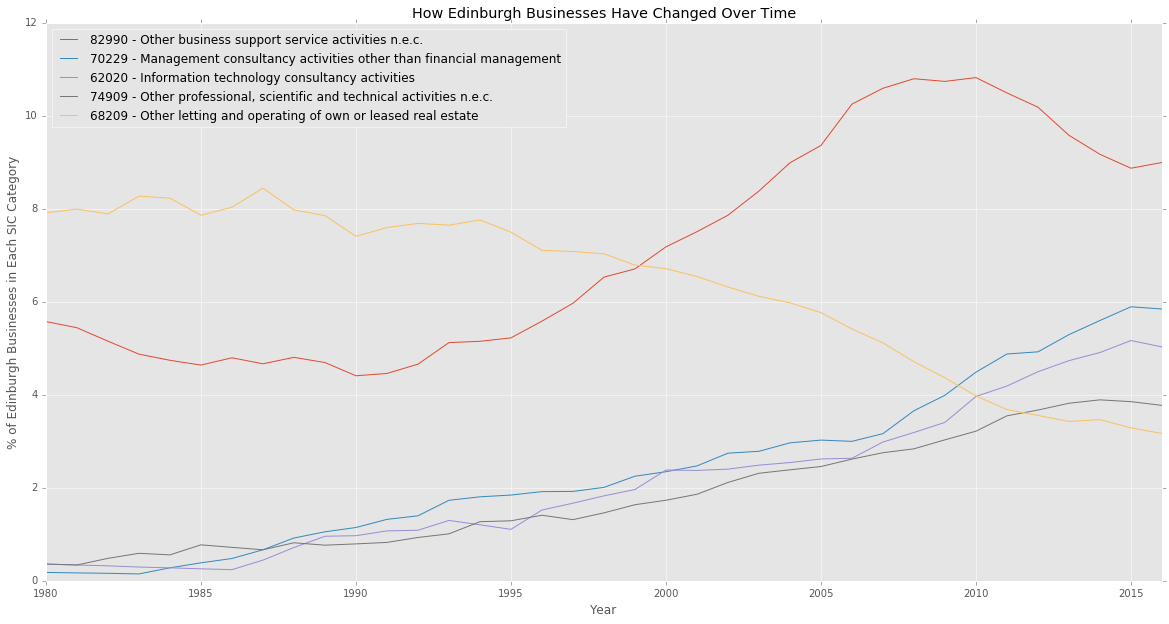

In [8]:
edi_percs.head().transpose().plot(figsize=(20,10))
plt.xlabel('Year')
plt.ylabel('% of Edinburgh Businesses in Each SIC Category')
plt.title('How Edinburgh Businesses Have Changed Over Time')
plt.show()
# Unsurprisingly, IT consulting and science/tech have increased since the 80s.
# Management consulting has also grown massively.